In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 設定隨機種子與裝置
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


df = pd.read_csv("SICK_filtered.tsv", sep="\t")
print("原始資料形狀:", df.shape)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["entailment_label"])
print("訓練集形狀:", df_train.shape, "測試集形狀:", df_test.shape)


def tokenize(text):
    return text.lower().split()

# 建立詞彙（以訓練集內所有句子合併計算詞頻）
all_texts = df_train["sentence_A"].tolist() + df_train["sentence_B"].tolist()
from collections import Counter
counter = Counter()
for t in all_texts:
    counter.update(tokenize(t))
    
max_vocab_size = 10000
# 保留 <PAD> 與 <UNK>
vocab = {"<PAD>": 0, "<UNK>": 1}
for word, freq in counter.most_common(max_vocab_size - 2):
    vocab[word] = len(vocab)
vocab_size = len(vocab)
print("詞彙大小:", vocab_size)

def text_to_ids(text, vocab, max_length=50):
    tokens = tokenize(text)
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    if len(ids) < max_length:
        ids = ids + [vocab["<PAD>"]] * (max_length - len(ids))
    else:
        ids = ids[:max_length]
    return ids

max_length = 50

原始資料形狀: (9840, 3)
訓練集形狀: (7872, 3) 測試集形狀: (1968, 3)
詞彙大小: 2439


In [3]:
class SICKDataset(Dataset):
    def __init__(self, df, vocab, max_length):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.max_length = max_length
        self.sentences_A = df["sentence_A"].tolist()
        self.sentences_B = df["sentence_B"].tolist()
        self.labels = df["entailment_label"].tolist()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        sent_A = self.sentences_A[idx]
        sent_B = self.sentences_B[idx]
        # 轉換成 token id 列表
        ids_A = torch.tensor(text_to_ids(sent_A, self.vocab, self.max_length), dtype=torch.long)
        ids_B = torch.tensor(text_to_ids(sent_B, self.vocab, self.max_length), dtype=torch.long)
        label = self.labels[idx]
        return ids_A, ids_B, label


le = LabelEncoder()
df_train["label_enc"] = le.fit_transform(df_train["entailment_label"])
df_test["label_enc"] = le.transform(df_test["entailment_label"])
num_classes = len(le.classes_)
print("標籤類別:", le.classes_)

def create_dataloader(df, vocab, max_length, batch_size, shuffle=True):
    dataset = SICKDataset(df, vocab, max_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

標籤類別: ['CONTRADICTION' 'ENTAILMENT' 'NEUTRAL']


In [ ]:
class EmbeddingDNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, dropout=0.5):
        super(EmbeddingDNNClassifier, self).__init__()
        self.embedding_A = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embedding_B = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.fc = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, num_classes)
        )
    
    def forward(self, ids_A, ids_B):

        emb_A = self.embedding_A(ids_A)
        emb_B = self.embedding_B(ids_B)
        pooled_A = emb_A.mean(dim=1)
        pooled_B = emb_B.mean(dim=1)
        features = torch.cat([pooled_A, pooled_B], dim=1)  
        logits = self.fc(features)
        return logits


def train_and_evaluate(model, train_loader, test_loader, num_epochs, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    epoch_list = []
    
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for ids_A, ids_B, labels in train_loader:
            labels = torch.tensor(le.transform(labels), dtype=torch.long).to(device)
            ids_A, ids_B = ids_A.to(device), ids_B.to(device)
            
            optimizer.zero_grad()
            outputs = model(ids_A, ids_B)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * ids_A.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / total
        train_acc = correct / total
        
        model.eval()
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for ids_A, ids_B, labels in test_loader:
                labels = torch.tensor(le.transform(labels), dtype=torch.long).to(device)
                ids_A, ids_B = ids_A.to(device), ids_B.to(device)
                outputs = model(ids_A, ids_B)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item() * ids_A.size(0)
                _, preds = torch.max(outputs, 1)
                test_correct += (preds == labels).sum().item()
                test_total += labels.size(0)
        
        test_loss = test_running_loss / test_total
        test_acc = test_correct / test_total
        
        epoch_list.append(epoch)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
    
    return epoch_list, train_losses, test_losses, train_accuracies, test_accuracies


batch_size = 512
num_epochs = 10
learning_rate = 0.001


X = df_train.copy()


[比例 100%] 訓練資料筆數: 7872
Epoch 1: Train Loss=1.0557, Train Acc=0.5149 | Test Loss=0.9884, Test Acc=0.5686
Epoch 2: Train Loss=0.9697, Train Acc=0.5686 | Test Loss=0.9398, Test Acc=0.5686
Epoch 3: Train Loss=0.9421, Train Acc=0.5686 | Test Loss=0.9304, Test Acc=0.5686
Epoch 4: Train Loss=0.9296, Train Acc=0.5686 | Test Loss=0.9183, Test Acc=0.5686
Epoch 5: Train Loss=0.9131, Train Acc=0.5687 | Test Loss=0.9051, Test Acc=0.5686
Epoch 6: Train Loss=0.8941, Train Acc=0.5706 | Test Loss=0.8875, Test Acc=0.5701
Epoch 7: Train Loss=0.8705, Train Acc=0.5762 | Test Loss=0.8691, Test Acc=0.5752
Epoch 8: Train Loss=0.8457, Train Acc=0.5861 | Test Loss=0.8487, Test Acc=0.5823
Epoch 9: Train Loss=0.8186, Train Acc=0.6004 | Test Loss=0.8302, Test Acc=0.5833
Epoch 10: Train Loss=0.7951, Train Acc=0.6056 | Test Loss=0.8156, Test Acc=0.5950
分類報告 (Train Subset 100%):
               precision    recall  f1-score   support

CONTRADICTION       0.60      0.45      0.51       285
   ENTAILMENT       0.54    

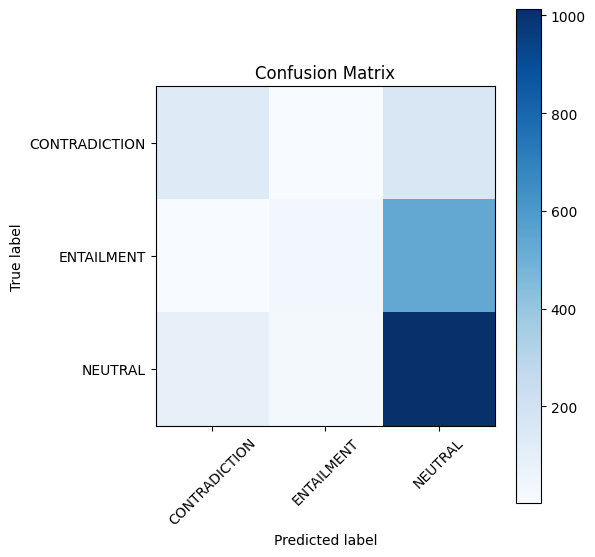


[比例 50%] 訓練資料筆數: 3936
Epoch 1: Train Loss=1.0984, Train Acc=0.3356 | Test Loss=1.0539, Test Acc=0.5661
Epoch 2: Train Loss=1.0258, Train Acc=0.5671 | Test Loss=0.9858, Test Acc=0.5686
Epoch 3: Train Loss=0.9724, Train Acc=0.5701 | Test Loss=0.9497, Test Acc=0.5686
Epoch 4: Train Loss=0.9545, Train Acc=0.5704 | Test Loss=0.9437, Test Acc=0.5686
Epoch 5: Train Loss=0.9446, Train Acc=0.5704 | Test Loss=0.9401, Test Acc=0.5686
Epoch 6: Train Loss=0.9387, Train Acc=0.5704 | Test Loss=0.9364, Test Acc=0.5686
Epoch 7: Train Loss=0.9307, Train Acc=0.5704 | Test Loss=0.9300, Test Acc=0.5686
Epoch 8: Train Loss=0.9227, Train Acc=0.5704 | Test Loss=0.9244, Test Acc=0.5686
Epoch 9: Train Loss=0.9168, Train Acc=0.5704 | Test Loss=0.9184, Test Acc=0.5686
Epoch 10: Train Loss=0.9082, Train Acc=0.5711 | Test Loss=0.9123, Test Acc=0.5686
分類報告 (Train Subset 50%):
               precision    recall  f1-score   support

CONTRADICTION       0.00      0.00      0.00       285
   ENTAILMENT       0.00      

/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

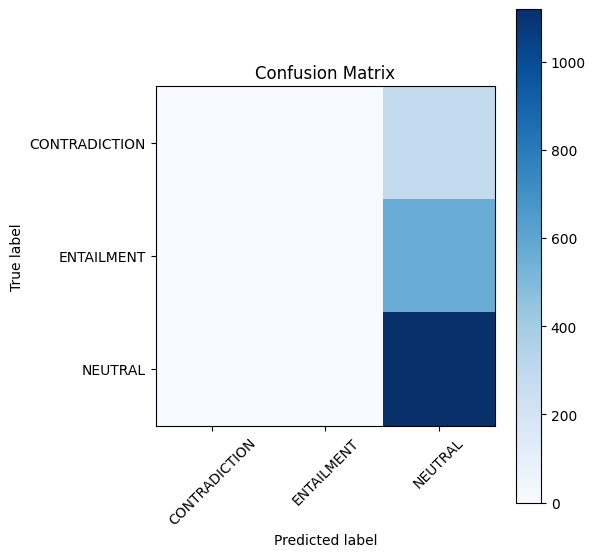


[比例 25%] 訓練資料筆數: 1968
Epoch 1: Train Loss=1.0755, Train Acc=0.5518 | Test Loss=1.0540, Test Acc=0.5686
Epoch 2: Train Loss=1.0389, Train Acc=0.5808 | Test Loss=1.0195, Test Acc=0.5686
Epoch 3: Train Loss=1.0043, Train Acc=0.5808 | Test Loss=0.9884, Test Acc=0.5686
Epoch 4: Train Loss=0.9745, Train Acc=0.5808 | Test Loss=0.9653, Test Acc=0.5686
Epoch 5: Train Loss=0.9533, Train Acc=0.5808 | Test Loss=0.9533, Test Acc=0.5686
Epoch 6: Train Loss=0.9445, Train Acc=0.5808 | Test Loss=0.9501, Test Acc=0.5686
Epoch 7: Train Loss=0.9411, Train Acc=0.5808 | Test Loss=0.9482, Test Acc=0.5686
Epoch 8: Train Loss=0.9367, Train Acc=0.5808 | Test Loss=0.9444, Test Acc=0.5686
Epoch 9: Train Loss=0.9333, Train Acc=0.5808 | Test Loss=0.9401, Test Acc=0.5686
Epoch 10: Train Loss=0.9259, Train Acc=0.5808 | Test Loss=0.9366, Test Acc=0.5686
分類報告 (Train Subset 25%):
               precision    recall  f1-score   support

CONTRADICTION       0.00      0.00      0.00       285
   ENTAILMENT       0.00      

/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

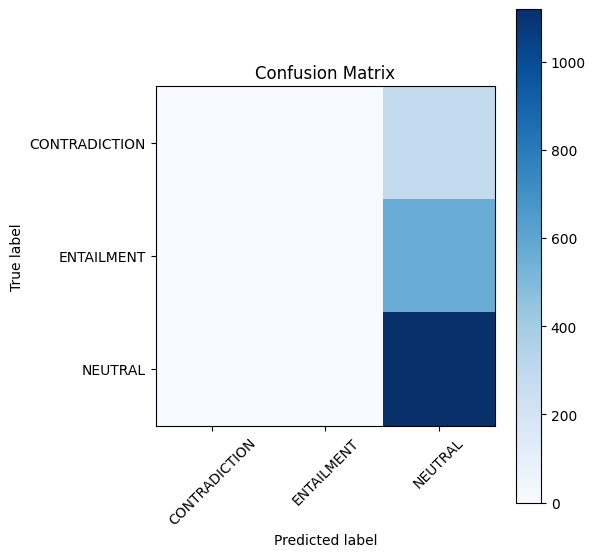


[比例 10%] 訓練資料筆數: 787
Epoch 1: Train Loss=1.1119, Train Acc=0.2808 | Test Loss=1.0970, Test Acc=0.2871
Epoch 2: Train Loss=1.0950, Train Acc=0.3075 | Test Loss=1.0801, Test Acc=0.4029
Epoch 3: Train Loss=1.0779, Train Acc=0.4206 | Test Loss=1.0635, Test Acc=0.5508
Epoch 4: Train Loss=1.0607, Train Acc=0.5388 | Test Loss=1.0470, Test Acc=0.5666
Epoch 5: Train Loss=1.0460, Train Acc=0.5591 | Test Loss=1.0305, Test Acc=0.5671
Epoch 6: Train Loss=1.0269, Train Acc=0.5616 | Test Loss=1.0140, Test Acc=0.5686
Epoch 7: Train Loss=1.0163, Train Acc=0.5629 | Test Loss=0.9983, Test Acc=0.5686
Epoch 8: Train Loss=1.0005, Train Acc=0.5616 | Test Loss=0.9839, Test Acc=0.5686
Epoch 9: Train Loss=0.9852, Train Acc=0.5604 | Test Loss=0.9717, Test Acc=0.5686
Epoch 10: Train Loss=0.9762, Train Acc=0.5616 | Test Loss=0.9620, Test Acc=0.5686
分類報告 (Train Subset 10%):
               precision    recall  f1-score   support

CONTRADICTION       0.00      0.00      0.00       285
   ENTAILMENT       0.00      0

/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

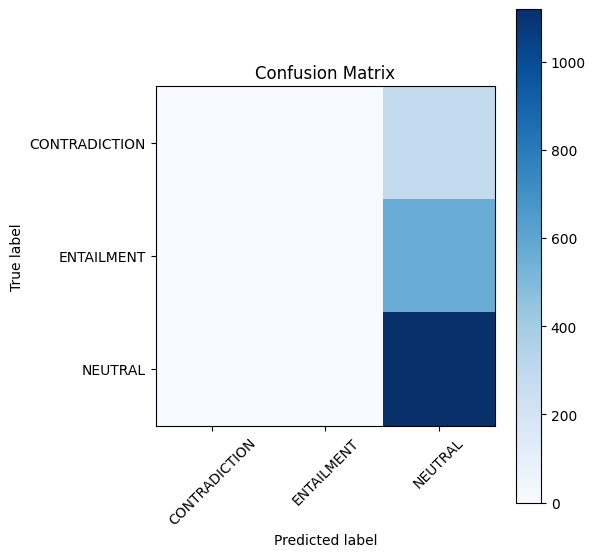

In [ ]:
fractions = [1.0, 0.5, 0.25, 0.1]

for frac in fractions:
    num_samples = int(len(X) * frac)
    df_train_subset = X.iloc[:num_samples].reset_index(drop=True)
    subset_percentage = int(frac * 100)
    #df_train_subset.to_csv(f"SICK_train_subset_{subset_percentage}.tsv", sep="\t", index=False)
    
    train_loader = create_dataloader(df_train_subset, vocab, max_length, batch_size, shuffle=True)
    test_loader = create_dataloader(df_test, vocab, max_length, batch_size, shuffle=False)
    
    print(f"\n[比例 {subset_percentage}%] 訓練資料筆數: {len(df_train_subset)}")
    
    model = EmbeddingDNNClassifier(vocab_size, embed_dim=128, num_classes=num_classes, dropout=0.5)
    model.to(device)
    
    epoch_list, train_losses, test_losses, train_accs, test_accs = train_and_evaluate(model, train_loader, test_loader, num_epochs, learning_rate)
    
    # 畫圖
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(epoch_list, train_losses, label="Train Loss")
    axs[0].plot(epoch_list, test_losses, label="Test Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title(f"Loss vs Epoch (Train Subset {subset_percentage}%)")
    axs[0].legend()
    
    axs[1].plot(epoch_list, train_accs, label="Train Acc")
    axs[1].plot(epoch_list, test_accs, label="Test Acc")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title(f"Accuracy vs Epoch (Train Subset {subset_percentage}%)")
    axs[1].legend()
    
    plt.tight_layout()
    plt.savefig(f"EmbeddingDNN_SICK_{subset_percentage}.png")
    plt.close()
    
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for ids_A, ids_B, labels in test_loader:
            labels_tensor = torch.tensor(le.transform(labels), dtype=torch.long).to(device)
            ids_A, ids_B = ids_A.to(device), ids_B.to(device)
            outputs = model(ids_A, ids_B)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_tensor.cpu().numpy())
    
    print(f"分類報告 (Train Subset {subset_percentage}%):")
    print(classification_report(all_labels, all_preds, target_names=le.classes_))

    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(le.classes_))
    plt.xticks(tick_marks, le.classes_, rotation=45)
    plt.yticks(tick_marks, le.classes_)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
